In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
from scipy.special import exp1,factorial
from scipy.stats import binom,nbinom

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Section 1: compute values for y axis correction

Goal: compute length (in kb) of exome on chrom 1 with potential for a LoF/Missense/Synonymous site

Data sources: 
- UKB BED file for WES targets (https://biobank.ndph.ox.ac.uk/ukb/refer.cgi?id=3803)
- potential LoF sites from Zeng et al. 2023, file `gnomad_lofs_with_misannotation_probabilitites.tsv.gz` (https://zenodo.org/records/10403680)

For **synonymous** sites: this is 1/3 of the total length of exome sequence 

For **missense** sites: this is 2/3 of the total length of exome sequence

We also need to divide each SFS entry by the _proportion of snps kept_ in the downsampling procedure. E.g., for synonymous variants, chrom 1 contained 247,378 SNPs, but we downsampled to 32,320, so we will divied by 32320/247378=0.1302. Same for missense (for LoF we kept all variants, so this proportion is just 1). 

For **LoF** sites: we will use the list of potential LoF sites from Zeng et al. to compute # potential LoFs in sequencing targets directly.

In [2]:
## First compute the proportions...
# proportion of sites kept
prop_kept_syn = 32320/247378
prop_kept_mis = 32320/505963
print(f"Prop. kept for syn: {prop_kept_syn}")
print(f"Prop. kept for mis: {prop_kept_mis}")

Prop. kept for syn: 0.130650259926105
Prop. kept for mis: 0.06387818872130967


In [3]:
## Now compute length of exome sequence. Starting with  UKB target regions on chromosome 1...
bed_file = "../empirical/subsampling_SIR_v20250127/metadata/xgen_plus_spikein.GRCh38.bed"
df_bed = pd.read_csv(bed_file, sep='\t', header=None, names=["chr", "start", "end"])
df_bed["length"] = df_bed["end"] - df_bed["start"]
df_bed

,chr,start,end,length
0,chr1,69090,70008,918
1,chr1,450739,451678,939
2,chr1,685715,686654,939
3,chr1,925941,926013,72
4,chr1,930154,930336,182
...,...,...,...,...
204824,chrY,57190939,57191085,146
204825,chrY,57191797,57191999,202
204826,chrY,57192602,57192708,106
204827,chrY,57194042,57194127,85


In [4]:
# sanity check - sum of lengths should be around 39 Mbp
df_bed['length'].sum()

38997831

In [5]:
# length of chromosome 1 regions only
df_chr1_bed=df_bed[df_bed['chr']=='chr1']
chr1_len = df_chr1_bed['length'].sum()
chr1_len

3924065

In [6]:
# length (in kb) of "synonymous" exome on chr1
len_syn = (1/3)*chr1_len/1000
len_syn # length factor for synonymous sites

1308.0216666666665

In [7]:
# length (in kb) of "missense" exome on chr1
len_mis = (2/3)*df_chr1_bed["length"].sum()/1000
len_mis # length factor for synonymous sites

2616.043333333333

In [8]:
## potential LoF sites - from Zeng et al. results
lofsites = pd.read_csv('../empirical/subsampling_SIR_v20250127/metadata/gnomad_lofs_with_misannotation_probabilities.tsv',delimiter='\t')

/var/folders/r0/wf2xsjdx3h366x3_hj3b7xdc0000gp/T/ipykernel_79030/1845316902.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  lofsites = pd.read_csv('../empirical/subsampling_SIR_v20250127/metadata/gnomad_lofs_with_misannotation_probabilities.tsv',delimiter='\t')


In [9]:
# filter to chrom1
lofsites_chr1 = lofsites[lofsites['chr']==1]
lofsites_chr1

,Unnamed: 0,ensg,locus,ref,alt,lof,csq,lof_flag,mean_proportion,context,...,median_coverage,symbol,chr,start,end,low_map_or_segdup,num_gt,consequence,p_misannotation,pos_hg38
908252,908252,ENSG00000107404,1:1271578,G,['A'],['HC'],['stop_gained'],[{'None'}],[0.950484],CCA,...,33.0,DVL1,1,1271577,1271578,False,250312.0,['stop_gained'],0.009288,1336198.0
908253,908253,ENSG00000107404,1:1271592,A,['T'],['HC'],['stop_gained'],[{'None'}],[0.950484],TTG,...,32.0,DVL1,1,1271591,1271592,False,250312.0,['stop_gained'],0.009494,1336212.0
908254,908254,ENSG00000107404,1:1271596,C,['A'],['HC'],['stop_gained'],[{'None'}],[0.950484],GGA,...,32.0,DVL1,1,1271595,1271596,False,250312.0,['stop_gained'],0.009434,1336216.0
908255,908255,ENSG00000107404,1:1271617,C,['A'],['HC'],['stop_gained'],[{'None'}],[0.950484],GGA,...,26.0,DVL1,1,1271616,1271617,False,250312.0,['stop_gained'],0.009434,1336237.0
908256,908256,ENSG00000107404,1:1271632,C,['A'],['HC'],['stop_gained'],[{'None'}],[0.950484],GGG,...,23.0,DVL1,1,1271631,1271632,False,250312.0,['stop_gained'],0.009419,1336252.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2981843,2981843,ENSG00000168679,1:110931913,G,"['C', 'T']","['HC', 'HC']","['stop_gained', 'stop_gained']","[{'PHYLOCSF_WEAK'}, {'PHYLOCSF_WEAK'}]","[0.693263, 0.693263]",ACA,...,97.0,SLC16A4,1,110931912,110931913,False,250312.0,"['stop_gained', 'stop_gained']",0.009496,110389291.0
2981844,2981844,ENSG00000168679,1:110931921,G,['A'],['HC'],['stop_gained'],[{'PHYLOCSF_WEAK'}],[0.693263],CCA,...,91.0,SLC16A4,1,110931920,110931921,False,250312.0,['stop_gained'],0.009488,110389299.0
2981845,2981845,ENSG00000168679,1:110931927,T,['A'],['HC'],['stop_gained'],[{'PHYLOCSF_WEAK'}],[0.693263],GAA,...,85.0,SLC16A4,1,110931926,110931927,False,250312.0,['stop_gained'],0.009522,110389305.0
2981846,2981846,ENSG00000168679,1:110931933,C,['A'],['HC'],['stop_gained'],[{'PHYLOCSF_WEAK'}],[0.693263],GGA,...,82.0,SLC16A4,1,110931932,110931933,False,250312.0,['stop_gained'],0.009512,110389311.0


In [10]:
## some functions to use to compute which region from bed file a particular variant sits in...
def in_region(row):
    return interval_idx.contains(row['pos_hg38']).any() # return True if position in at least one region

def find_region_index(row):
    mask = interval_idx.contains(row['pos_hg38'])  # Vectorized check
    matching_indices = df_chr1_bed.index[mask]  # Get matching indices
    return matching_indices[0] if not matching_indices.empty else None  # Return first match or None
    
df_chr1_bed['interval'] = pd.IntervalIndex.from_arrays(df_chr1_bed['start'], df_chr1_bed['end'], closed='both')
interval_idx = pd.IntervalIndex(df_chr1_bed['interval'])

/var/folders/r0/wf2xsjdx3h366x3_hj3b7xdc0000gp/T/ipykernel_79030/959839440.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chr1_bed['interval'] = pd.IntervalIndex.from_arrays(df_chr1_bed['start'], df_chr1_bed['end'], closed='both')


In [11]:
lofsites_chr1['in_region'] = lofsites_chr1.apply(in_region, axis=1)
lofsites_chr1['region_index'] = lofsites_chr1.apply(find_region_index, axis=1)

/var/folders/r0/wf2xsjdx3h366x3_hj3b7xdc0000gp/T/ipykernel_79030/3400125872.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lofsites_chr1['in_region'] = lofsites_chr1.apply(in_region, axis=1)
/var/folders/r0/wf2xsjdx3h366x3_hj3b7xdc0000gp/T/ipykernel_79030/3400125872.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lofsites_chr1['region_index'] = lofsites_chr1.apply(find_region_index, axis=1)


In [12]:
## Most snps are in one of the regions from bed file...
lofsites_chr1['in_region'].value_counts()

in_region
True     167616
False     31699
Name: count, dtype: int64

In [13]:
region_counts = lofsites_chr1['region_index'].value_counts().reindex(df_chr1_bed.index, fill_value=np.nan)

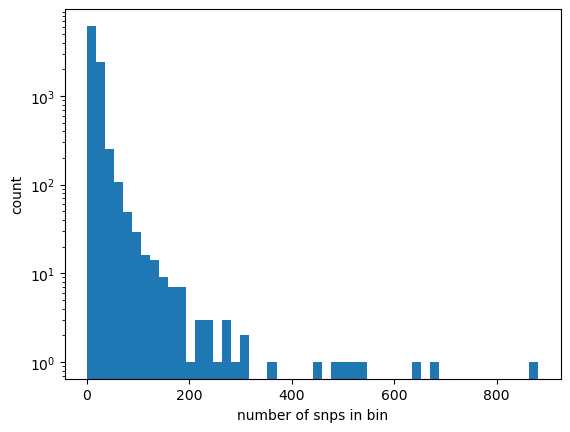

In [14]:
## Plot of number of snps per bin...
region_counts.hist(bins=50)
plt.yscale('log')
plt.grid(False)
plt.xlabel('number of snps in bin')
plt.ylabel('count')
plt.show()

In [15]:
## number of non-empty regions...
len(lofsites_chr1['region_index'].unique())

9137

In [16]:
len(lofsites_chr1[lofsites_chr1['in_region']==True]['locus'].unique())

167616

In [17]:
lofsites_chr1[lofsites_chr1['in_region']==True]['locus']

908252       1:1271578
908253       1:1271592
908254       1:1271596
908255       1:1271617
908256       1:1271632
              ...     
2981843    1:110931913
2981844    1:110931921
2981845    1:110931927
2981846    1:110931933
2981847    1:110931939
Name: locus, Length: 167616, dtype: object

In [18]:
## The length in kb of potential lof sequence is the # of sites in the bed regions/1000
len_lof = len(lofsites_chr1[lofsites_chr1['in_region']==True])/1000
len_lof

167.616

In [19]:
## In summary...
print(f'Length for synonymous: {len_syn}')
print(f'Length for missense: {len_mis}')
print(f'Length for lof: {len_lof}')

Length for synonymous: 1308.0216666666665
Length for missense: 2616.043333333333
Length for lof: 167.616


In [20]:
# sfs+df

### Section 2: SFS plots with these y axis corrections

In [21]:
## plotting params
plt.rcParams['axes.labelsize'] = 8    
plt.rcParams['axes.titlesize'] = 9    
plt.rcParams['xtick.labelsize'] = 8   
plt.rcParams['ytick.labelsize'] = 8 
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['font.family']='Arial'
# Define plot parameters and styles
colors = ['#440154',  # Dark Purple (Viridis)
          '#3b528b',  # Blue (Viridis)
          '#21918c',  # Teal (Viridis)
          '#5ec962',  # Green (Viridis)
          '#f03b20',  # Red (Warm)
          '#fd8d3c',  # Orange (Warm)
          '#fdae61',  # Light Orange (Warm)

          '#fee08b']  # Light Yellow (Warm)


synonymous
170.89337073897704
missense
167.10810974979066
lof
167.616


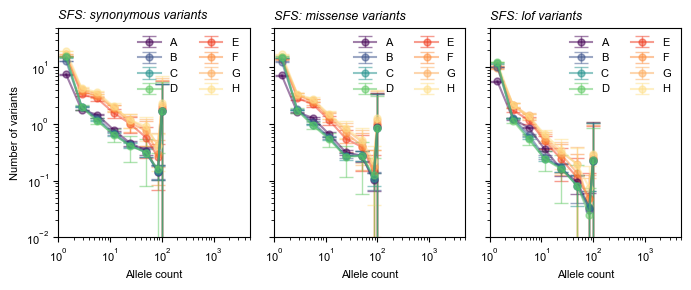

In [23]:
nbins = 13
n=10000
sfs_unif = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_lof_uniformgeo_nSIR10000_nSIRreps10.SIRsfs', sep=' ')
sfs_unif_grouped = sfs_unif.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std'])
sfs_unif_avg = sfs_unif_grouped['mean']

# Generate log bins up to 100
log_bins = np.logspace(np.log10(1), np.log10(n/2), num=nbins)
log_bins = np.unique(np.round(log_bins))  # Ensure unique, rounded bin edges

# Find the index where bins exceed 100
log_bins = log_bins[log_bins <= 100]  # Keep bins only up to 100
log_bins = np.append(log_bins, [100, np.inf])  # Add final bin for values >100

# Compute bin centers
bin_centers = np.sqrt(log_bins[:-1] * log_bins[1:])
bin_centers[-1] = 100  # Assign a reasonable center for the last bin
# log_bins = np.logspace(np.log10(1), np.log10(n/2), num=nbins)  # Start from 1 instead of 10
# log_bins = np.unique(np.round(log_bins))
# bin_centers = np.sqrt(log_bins[:-1] * log_bins[1:])

vartypes = ['synonymous', 'missense', 'lof']
centers_geo = ['centerE16N4', 'centerE9N9', 'centerE6N4']
w_list_geo = ['50000', '100000', '150000']
labs_geo = ['A', 'B', 'C', 'D']

centers_pca = ['centerX19Y4']
w_list_pca = [0.0015, 0.0025, 0.005]
labs_pca = ['E', 'F', 'G', 'H']



# Create a 3-panel plot
fig, axes = plt.subplots(1, 3, figsize=(7.01, 3), sharex=True, sharey=True)
sfs_data = []
for k, vt in enumerate(vartypes):
    ax = axes[k]
    print(vt)
    if vt=='synonymous':
        scale_factor = len_syn*prop_kept_syn # also divide by prop kept
    elif vt=='missense':
        scale_factor = len_mis*prop_kept_mis # also divide by prop kept
    elif vt=='lof':
        scale_factor = len_lof
    print(scale_factor)
    
    # Process PCA data
    sfs_unif_pca = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_{vt}_uniformpca_nSIR10000_nSIRreps10.SIRsfs', sep=' ')
    sfs_unif_pca_grouped = sfs_unif_pca.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std'])
    sfs_unif_pca_avg = sfs_unif_pca_grouped['mean']/scale_factor
    sfs_unif_pca_std = sfs_unif_pca_grouped['std']/scale_factor
    
    sfs_unif_pca_binned, _ = np.histogram(sfs_unif_pca_avg.index, bins=log_bins, weights=sfs_unif_pca_avg.values)
    std_unif_pca_binned, _ = np.histogram(sfs_unif_pca_avg.index, bins=log_bins, weights=sfs_unif_pca_std.values)

    for i in range(len(bin_centers)):
        sfs_data.append([vt, "H", bin_centers[i], sfs_unif_pca_binned[i], std_unif_pca_binned[i]])  
    
    for j, w in enumerate(w_list_pca):
        all_sfs_avg = []
        all_sfs_std = []

        for center in centers_pca:
            sfs = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_{vt}_{center}pca{w}_nSIR10000_nSIRreps10.SIRsfs', delimiter=' ')
            sfs_avg_grouped = sfs.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std'])
            all_sfs_avg.append(sfs_avg_grouped['mean']/scale_factor)
            all_sfs_std.append(sfs_avg_grouped['std']/scale_factor)


        sfs_avg_final = pd.concat(all_sfs_avg, axis=1).values
        sfs_avg_forindex = pd.concat(all_sfs_avg, axis=1)
        sfs_std_final = pd.concat(all_sfs_std, axis=1).values
        sfs_forindex = sfs_avg_forindex.mean(axis=1)
        sfs_avg_binned, _ = np.histogram(sfs_forindex.index, 
                                          bins=log_bins,
                                          weights=sfs_avg_final.flatten())
        std_gaussian_binned, _ = np.histogram(sfs_forindex.index,
                                               bins=log_bins,
                                               weights=sfs_std_final.flatten())
        for i in range(len(bin_centers)):
            sfs_data.append([vt, labs_pca[j], bin_centers[i], sfs_avg_binned[i], std_gaussian_binned[i]])



        ax.errorbar(bin_centers, sfs_avg_binned, yerr=std_gaussian_binned, label=labs_pca[j], 
                    linestyle='-', marker='o', capsize=5, markersize=5, elinewidth=1, 
                    alpha=0.5, color=colors[j+4])
    ax.errorbar(bin_centers, sfs_unif_pca_binned, yerr=std_unif_pca_binned, linestyle='-', 
                label=labs_pca[3], marker='o', capsize=5, markersize=5, elinewidth=1, 
                alpha=0.5, color=colors[7])

    # Load and process uniform data for geo
    sfs_unif_geo = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_{vt}_uniformgeo_nSIR10000_nSIRreps10.SIRsfs', sep=' ')
    sfs_unif_geo_grouped = sfs_unif_geo.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std'])
    sfs_unif_geo_avg = sfs_unif_geo_grouped['mean']/scale_factor
    sfs_unif_geo_std = sfs_unif_geo_grouped['std']/scale_factor

    # Binning for uniform data (geo)
    sfs_unif_geo_binned, _ = np.histogram(sfs_unif_geo_avg.index, bins=log_bins, weights=sfs_unif_geo_avg.values)
    std_unif_geo_binned, _ = np.histogram(sfs_unif_geo_avg.index, bins=log_bins, weights=sfs_unif_geo_std.values)
    for i in range(len(bin_centers)):
        sfs_data.append([vt, "D", bin_centers[i], sfs_unif_geo_binned[i], std_unif_geo_binned[i]])

    # Process and plot Gaussian data for geo
    for j, w in enumerate(w_list_geo):
        all_sfs_avg = []
        all_sfs_std = []

        for center in centers_geo:
            sfs = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_{vt}_{center}geo{w}_nSIR10000_nSIRreps10.SIRsfs', delimiter=' ')
            sfs_avg_grouped = sfs.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std'])
            all_sfs_avg.append(sfs_avg_grouped['mean']/scale_factor)
            all_sfs_std.append(sfs_avg_grouped['std']/scale_factor)
        
        combined_sfs_avg = pd.concat(all_sfs_avg, axis=1)
        combined_sfs_std = pd.concat(all_sfs_std, axis=1)
        sfs_avg_final = combined_sfs_avg.mean(axis=1)
        sfs_std_final = combined_sfs_std.std(axis=1)

        sfs_avg_binned, _ = np.histogram(sfs_avg_final.index, bins=log_bins, weights=sfs_avg_final.values)
        std_gaussian_binned, _ = np.histogram(sfs_avg_final.index, bins=log_bins, weights=sfs_std_final.values)
        for i in range(len(bin_centers)):
            sfs_data.append([vt, labs_geo[j], bin_centers[i], sfs_avg_binned[i], std_gaussian_binned[i]])

        ax.errorbar(bin_centers, sfs_avg_binned, yerr=std_gaussian_binned, label=labs_geo[j], 
                    linestyle='-', marker='o', capsize=5, markersize=5, elinewidth=1, 
                    alpha=0.5, color=colors[j])

    # Plot uniform data for geo
    ax.errorbar(bin_centers, sfs_unif_geo_binned, yerr=std_unif_geo_binned, 
            linestyle='-', label=labs_geo[3], marker='o', capsize=5, 
            markersize=5, elinewidth=1, alpha=0.5, color=colors[3])
    
    # Customize each subplot
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-2, 5e1)
    ax.set_xlim(1e0,5e3)
    ax.set_title(f'SFS: {vt} variants', loc='left', fontstyle='italic')
    ax.set_xlabel("Allele count")
    if k == 0:
        ax.set_ylabel("Number of variants")
    # ax.legend(loc='upper right', ncol=2, frameon=False)
    handles, labels = ax.get_legend_handles_labels()
    order = [4,5,6,7,0,1,2,3]  # Define the desired order (e.g., reorder to ['Bird', 'Dog', 'Cat'])
    ax.legend([handles[i] for i in order], [labels[i] for i in order],loc='upper right',ncol=2,frameon=False)

plt.tight_layout()
plt.savefig(f'sfs_syn_miss_lof_v20250217.pdf')
plt.show()

sfs_df = pd.DataFrame(sfs_data, columns=['Variant_Type', 'Panel', 'Bin_Center', 'Binned_SFS', 'Binned_Std'])
sfs_df.to_csv("sfs_binned_summary.csv", index=False)

In [26]:
sfs_df[(sfs_df['Variant_Type']=='lof')&(sfs_df['Panel']=='A')]

,Variant_Type,Panel,Bin_Center,Binned_SFS,Binned_Std
168,lof,A,1.414214,5.652802,0.040074
169,lof,A,2.828427,1.237750,0.038960
170,lof,A,5.656854,0.866862,0.024959
171,lof,A,11.661904,0.357364,0.026111
172,lof,A,24.392622,0.158099,0.035577
173,lof,A,49.849774,0.093269,0.035526
174,lof,A,84.261498,0.033211,0.027117
175,lof,A,100.000000,0.227106,0.848949


In [155]:
bin_centers

array([1.41421356e+00, 2.82842712e+00, 5.29150262e+00, 9.89949494e+00,
       1.90787840e+01, 3.64142829e+01, 7.06965346e+01, 1.36095555e+02,
       2.62289916e+02, 5.04777179e+02, 9.71750997e+02, 1.87172461e+03,
       3.60347055e+03])

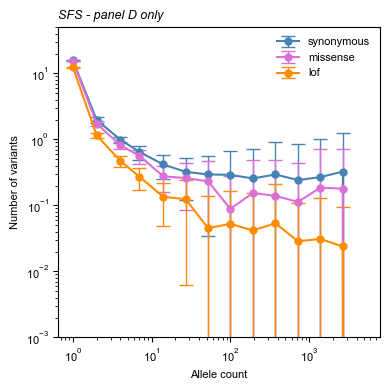

In [24]:
# Create a 1-panel plot for all variant types on the same axis
fig, ax = plt.subplots(figsize=(4, 4))  # Use only 1 axis
colors_2 = ['steelblue','orchid','darkorange']
for k, vt in enumerate(vartypes):
    
    if vt == 'synonymous':
        scale_factor = len_syn * prop_kept_syn
    elif vt == 'missense':
        scale_factor = len_mis * prop_kept_mis
    elif vt == 'lof':
        scale_factor = len_lof  
    
    # Process PCA data for line D only
    sfs_unif_pca = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_{vt}_uniformpca_nSIR10000_nSIRreps10.SIRsfs', sep=' ')
    sfs_unif_pca_grouped = sfs_unif_pca.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std'])
    sfs_unif_pca_avg = sfs_unif_pca_grouped['mean'] / scale_factor
    sfs_unif_pca_std = sfs_unif_pca_grouped['std'] / scale_factor

    # Create log bins
    log_bins = np.logspace(np.log10(1), np.log10(sfs_unif_pca_avg.index.max()), num=nbins)
    log_bins = np.unique(np.round(log_bins))

    # Process Geo data for line D only
    sfs_unif_geo = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_{vt}_uniformgeo_nSIR10000_nSIRreps10.SIRsfs', sep=' ')
    sfs_unif_geo_grouped = sfs_unif_geo.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std'])
    sfs_unif_geo_avg = sfs_unif_geo_grouped['mean'] / scale_factor
    sfs_unif_geo_std = sfs_unif_geo_grouped['std'] / scale_factor

    # Binning for Geo data (line D)
    sfs_unif_geo_binned, _ = np.histogram(sfs_unif_geo_avg.index, bins=log_bins, weights=sfs_unif_geo_avg.values)
    std_unif_geo_binned, _ = np.histogram(sfs_unif_geo_avg.index, bins=log_bins, weights=sfs_unif_geo_std.values)
    
    ax.errorbar(log_bins[:-1], sfs_unif_geo_binned, yerr=std_unif_geo_binned, linestyle='-', 
                label=f'{vt}', marker='o', capsize=5, markersize=5, elinewidth=1, 
                alpha=1, color=colors_2[k])  # Use a different color for geo data

# Customize the plot
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-3, 5e1)
ax.set_title(f'SFS - panel D only', loc='left', fontstyle='italic')
ax.set_xlabel("Allele count")
ax.set_ylabel("Number of variants")

# Show the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right', ncol=1, frameon=False)

plt.tight_layout()
plt.savefig('sfs_panelDonly_v20250217.pdf')
plt.show()



In [25]:
## keep looking for "what proportion of new mutations are LoFs" - we have ~3%
## this scaling allows us to use base mutation rate -already accounts

### Section 3: Comparison with theory

In [58]:
### Step 1 - save SFS mean data from panel D plot above to arrays for easy plotting/comparison
# No binning
sfs_list = []
vartypes = ['synonymous','missense','lof']
for k, vt in enumerate(vartypes):
    
    if vt == 'synonymous':
        scale_factor = len_syn * prop_kept_syn
    elif vt == 'missense':
        scale_factor = len_mis * prop_kept_mis
    elif vt == 'lof':
        scale_factor = len_lof  

    sfs = pd.read_csv(f'../empirical/subsampling_SIR_v20250127/results/sfs/chr1_{vt}_centerE9N9geo50000_nSIR10000_nSIRreps10.SIRsfs', sep=' ')
    sfs_grouped = sfs.groupby('OBS_N')['COUNT_SITES'].agg(['mean', 'std'])
    sfs_avg = sfs_grouped['mean'] / scale_factor
    sfs_std = sfs_grouped['std'] / scale_factor
    sfs_list.append(sfs_avg)


In [27]:
vartypes

['synonymous', 'missense', 'lof']

In [59]:
# sfs_list

In [29]:
### Functions for theory

def get_lc(sigma,s):
    return np.sqrt(sigma**2/s)

def get_lambda_theory(w,sigma,s):
    lc = get_lc(sigma,s)
    term = (w / lc) ** 2
    if term <= 800:
        prod_term = np.exp(term) * exp1(term)
    else:
        prod_term = sum((factorial(k) / (-term)**k for k in range(7))) / term
    return (4*np.pi)/prod_term

def get_EP_theory(mu, s):
    return mu / s

def get_EPsquared_theory(mu, s, rho, sigma, w):
    lcs = get_lc(sigma, s)**2
    term = (w / np.sqrt(lcs)) ** 2
    if term <= 800:
        prod_term = np.exp(term) * exp1(term)
    else:
        prod_term = sum((factorial(k) / (-term)**k for k in range(7))) / term
    return (mu / (s ** 2 * rho * 4 * np.pi * lcs)) * prod_term + mu ** 2 / s ** 2

def get_sfs_theory(x,n,mu,s,rho,sigma,w):
    mean = get_EP_theory(mu,s)
    var = get_EPsquared_theory(mu,s,rho,sigma,w) - mean**2
    alpha = mean**2/var
    beta = mean/var
    return nbinom.pmf(x,alpha,beta/(beta+n))

def get_sfs_theory_unif(x,n,mu,s,N):
    mean = mu/s
    var = mu/(s*s*N)
    alpha = mean**2/var
    beta = mean/var
    return nbinom.pmf(x,alpha,beta/(beta+n))

In [92]:
### Step 2 - for each variant class try fitting combinations of params and report MSPE (mean square percentage error)

# MSPE will compute relative (percentage) error per SFS entry - to not bias towards singletons, other low frequency bins

## ranges 
sigma_list = np.linspace(10,50,10)#[1, 5, 10]##[10,25,50]#[1, 5, 10]
rho_list = np.linspace(0.1,50,50)#[1, 5, 10] # np.linspace(0.001,50,50)#[1,10,50]#[1, 5, 10]
s_list = np.logspace(-4,-2,10)#[1e-4, 1e-3, 1e-2] #np.logspace(-4,-2,10) #[1e-4, 1e-3, 1e-2]
w_list = [50]#[50,100,200,500]
mu_list = [1.25e-8]#2.5e-8]

# Given parameters
n = 10000
max_x = 10 # fit on first ten values

### synonymous variants

mspe_results = []  # store params and mspe

for sigma in sigma_list:
    for rho in rho_list:
        for s in s_list:
            for w in w_list:
                for mu in mu_list:
                    # theory
                    nb_dist = np.array([get_sfs_theory(y, n, mu, s, rho, sigma, w) * 1000 for y in np.arange(1, max_x+1)])
                    obs_dist = np.array(sfs_list[0][1:max_x+1])  # 0 = synonymous
                    # mean square percentage error
                    mspe = np.sum(((nb_dist - obs_dist)** 2/ (nb_dist) ) ) #/ (obs_dist) ### this version - chi square statistic
                    mspe_results.append((sigma, rho, s, w, mu, mspe, nb_dist))

# rank results
mspe_results.sort(key=lambda x: x[5])  # sorting by MSPE

# Print ranking
print(f"Ranking of parameter combinations by best fit (lowest MSPE), {vartypes[0]} variants:")
for rank, (sigma, rho, s, w, mu, mspe, _) in enumerate(mspe_results, 1):
    if rank<=30:
        print(f"{rank}. sigma={sigma}, rho={rho}, s={s:.1e}, w={w}, mu={mu:.2e}, MSPE={mspe:.5f}")

Ranking of parameter combinations by best fit (lowest MSPE), synonymous variants:
1. sigma=10.0, rho=3.1551020408163266, s=3.6e-03, w=50, mu=1.25e-08, MSPE=1.12631
2. sigma=18.88888888888889, rho=1.1183673469387756, s=3.6e-03, w=50, mu=1.25e-08, MSPE=1.14627
3. sigma=14.444444444444445, rho=2.136734693877551, s=3.6e-03, w=50, mu=1.25e-08, MSPE=1.23339
4. sigma=23.333333333333336, rho=1.1183673469387756, s=3.6e-03, w=50, mu=1.25e-08, MSPE=1.29217
5. sigma=10.0, rho=4.173469387755102, s=6.0e-03, w=50, mu=1.25e-08, MSPE=1.49780
6. sigma=27.77777777777778, rho=1.1183673469387756, s=6.0e-03, w=50, mu=1.25e-08, MSPE=1.50567
7. sigma=10.0, rho=2.136734693877551, s=3.6e-03, w=50, mu=1.25e-08, MSPE=1.60679
8. sigma=18.88888888888889, rho=2.136734693877551, s=6.0e-03, w=50, mu=1.25e-08, MSPE=1.62932
9. sigma=14.444444444444445, rho=1.1183673469387756, s=2.2e-03, w=50, mu=1.25e-08, MSPE=1.65889
10. sigma=14.444444444444445, rho=3.1551020408163266, s=6.0e-03, w=50, mu=1.25e-08, MSPE=1.70910
11. si

In [102]:
### missense variants

## ranges 
sigma_list = np.linspace(10,100,100)#[1, 5, 10]##[10,25,50]#[1, 5, 10]
rho_list = np.linspace(0.1,50,100)#[1, 5, 10] # np.linspace(0.001,50,50)#[1,10,50]#[1, 5, 10]
s_list = np.logspace(-4,-2,100)#[1e-4, 1e-3, 1e-2] #np.logspace(-4,-2,10) #[1e-4, 1e-3, 1e-2]
w_list = [50]#[50,100,200,500]
mu_list = [1.25e-8]#2.5e-8]


mspe_results = []  # store params and mspe

for sigma in sigma_list:
    for rho in rho_list:
        for s in s_list:
            for w in w_list:
                for mu in mu_list:
                    # theory
                    nb_dist = np.array([get_sfs_theory(y, n, mu, s, rho, sigma, w) * 1000 for y in np.arange(1, max_x+1)])
                    obs_dist = np.array(sfs_list[1][1:max_x+1])  # 1 = missense
                    # mean square percentage error
                    mspe = np.sum(((nb_dist - obs_dist)** 2/ (nb_dist) ) )#np.mean(((nb_dist - obs_dist) ) ** 2) #/ (obs_dist)
                    mspe_results.append((sigma, rho, s, w, mu, mspe, nb_dist))

# rank results
mspe_results.sort(key=lambda x: x[5])  # sorting by MSPE

# Print ranking
print(f"Ranking of parameter combinations by best fit (lowest MSPE), {vartypes[1]} variants:")
for rank, (sigma, rho, s, w, mu, mspe, _) in enumerate(mspe_results, 1):
    if rank<=30:
        print(f"{rank}. sigma={sigma}, rho={rho}, s={s:.1e}, w={w}, mu={mu:.2e}, MSPE={mspe:.5f}")

Ranking of parameter combinations by best fit (lowest MSPE), missense variants:
1. sigma=10.404040404040405, rho=1.6121212121212123, s=2.4e-03, w=50, mu=1.25e-08, MSPE=2.48013
2. sigma=20.909090909090907, rho=0.604040404040404, s=2.4e-03, w=50, mu=1.25e-08, MSPE=2.48032
3. sigma=13.636363636363637, rho=1.1080808080808082, s=2.4e-03, w=50, mu=1.25e-08, MSPE=2.48083
4. sigma=20.505050505050505, rho=0.604040404040404, s=2.4e-03, w=50, mu=1.25e-08, MSPE=2.48586
5. sigma=21.313131313131315, rho=0.604040404040404, s=2.5e-03, w=50, mu=1.25e-08, MSPE=2.48702
6. sigma=14.040404040404042, rho=1.1080808080808082, s=2.5e-03, w=50, mu=1.25e-08, MSPE=2.48734
7. sigma=20.909090909090907, rho=0.604040404040404, s=2.5e-03, w=50, mu=1.25e-08, MSPE=2.48900
8. sigma=10.404040404040405, rho=1.6121212121212123, s=2.5e-03, w=50, mu=1.25e-08, MSPE=2.48934
9. sigma=14.040404040404042, rho=1.1080808080808082, s=2.4e-03, w=50, mu=1.25e-08, MSPE=2.49013
10. sigma=21.313131313131315, rho=0.604040404040404, s=2.4e-

In [99]:
### lof variants

mspe_results = []  # store params and mspe

for sigma in sigma_list:
    for rho in rho_list:
        for s in s_list:
            for w in w_list:
                for mu in mu_list:
                    # theory
                    nb_dist = np.array([get_sfs_theory(y, n, mu, s, rho, sigma, w) * 1000 for y in np.arange(1, max_x+1)])
                    obs_dist = np.array(sfs_list[2][1:max_x+1])  # 2 = lof
                    # mean square percentage error
                    mspe = np.sum(((nb_dist - obs_dist)** 2/ (nb_dist) ) )#np.mean(((nb_dist - obs_dist) ) ** 2) #/ (obs_dist)
                    mspe_results.append((sigma, rho, s, w, mu, mspe, nb_dist))

# rank results
mspe_results.sort(key=lambda x: x[5])  # sorting by MSPE

# Print ranking
print(f"Ranking of parameter combinations by best fit (lowest MSPE), {vartypes[2]} variants:")
for rank, (sigma, rho, s, w, mu, mspe, _) in enumerate(mspe_results, 1):
    if rank<=30:
        print(f"{rank}. sigma={sigma}, rho={rho}, s={s:.1e}, w={w}, mu={mu:.2e}, MSPE={mspe:.5f}")

Ranking of parameter combinations by best fit (lowest MSPE), lof variants:
1. sigma=14.444444444444445, rho=1.1183673469387756, s=3.6e-03, w=50, mu=1.25e-08, MSPE=1.69622
2. sigma=10.0, rho=2.136734693877551, s=3.6e-03, w=50, mu=1.25e-08, MSPE=1.87793
3. sigma=14.444444444444445, rho=1.1183673469387756, s=6.0e-03, w=50, mu=1.25e-08, MSPE=2.55209
4. sigma=18.88888888888889, rho=1.1183673469387756, s=3.6e-03, w=50, mu=1.25e-08, MSPE=2.69667
5. sigma=50.0, rho=0.1, s=2.2e-03, w=50, mu=1.25e-08, MSPE=2.70236
6. sigma=10.0, rho=1.1183673469387756, s=2.2e-03, w=50, mu=1.25e-08, MSPE=2.70937
7. sigma=10.0, rho=2.136734693877551, s=6.0e-03, w=50, mu=1.25e-08, MSPE=2.71469
8. sigma=45.55555555555556, rho=0.1, s=2.2e-03, w=50, mu=1.25e-08, MSPE=2.89433
9. sigma=10.0, rho=1.1183673469387756, s=3.6e-03, w=50, mu=1.25e-08, MSPE=2.96385
10. sigma=41.111111111111114, rho=0.1, s=2.2e-03, w=50, mu=1.25e-08, MSPE=3.41392
11. sigma=50.0, rho=0.1, s=3.6e-03, w=50, mu=1.25e-08, MSPE=3.42064
12. sigma=14.44

In [32]:
# ### lof variants

# mspe_results = []  # store params and mspe

# for sigma in sigma_list:
#     for rho in rho_list:
#         for s in s_list:
#             for w in w_list:
#                 for mu in mu_list:
#                     # theory
#                     nb_dist = np.array([get_sfs_theory(y, n, mu, s, rho, sigma, w) * 1000 for y in np.arange(0, max_x)])
#                     obs_dist = np.array(sfs_list[2][:max_x])  # 2 = lof
#                     # mean square percentage error
#                     mspe = np.mean(((nb_dist - obs_dist) ) ** 2) #/ (obs_dist)
#                     mspe_results.append((sigma, rho, s, w, mu, mspe, nb_dist))

# # rank results
# mspe_results.sort(key=lambda x: x[5])  # sorting by MSPE

# # Print ranking
# print(f"Ranking of parameter combinations by best fit (lowest MSPE), {vartypes[2]} variants:")
# for rank, (sigma, rho, s, w, mu, mspe, _) in enumerate(mspe_results, 1):
#     if rank<=30:
#         print(f"{rank}. sigma={sigma}, rho={rho}, s={s:.1e}, w={w}, mu={mu:.2e}, MSPE={mspe:.5f}")

Ranking of parameter combinations by best fit (lowest MSPE), lof variants:
1. sigma=25, rho=1, s=1.0e-02, w=50, mu=1.25e-08, MSPE=2.26620
2. sigma=10, rho=1, s=1.0e-02, w=50, mu=1.25e-08, MSPE=2.28536
3. sigma=10, rho=1, s=1.0e-02, w=100, mu=1.25e-08, MSPE=2.28650
4. sigma=25, rho=1, s=1.0e-02, w=100, mu=1.25e-08, MSPE=2.31613
5. sigma=10, rho=1, s=1.0e-02, w=200, mu=1.25e-08, MSPE=2.39886
6. sigma=50, rho=1, s=1.0e-02, w=50, mu=1.25e-08, MSPE=2.49363
7. sigma=10, rho=10, s=1.0e-02, w=50, mu=1.25e-08, MSPE=2.56980
8. sigma=25, rho=1, s=1.0e-02, w=200, mu=1.25e-08, MSPE=2.58807
9. sigma=50, rho=1, s=1.0e-02, w=100, mu=1.25e-08, MSPE=2.62998
10. sigma=50, rho=1, s=1.0e-02, w=200, mu=1.25e-08, MSPE=2.72370
11. sigma=10, rho=10, s=1.0e-02, w=100, mu=1.25e-08, MSPE=2.73060
12. sigma=25, rho=10, s=1.0e-02, w=50, mu=1.25e-08, MSPE=2.73842
13. sigma=25, rho=1, s=1.0e-02, w=500, mu=1.25e-08, MSPE=2.73876
14. sigma=10, rho=1, s=1.0e-02, w=500, mu=1.25e-08, MSPE=2.73890
15. sigma=10, rho=50, s=1.

<!-- Observation here: the same set of sigma, rho, w, mu params fit well with each variant type such that s changes over variant class:

- synonymous: sigma=1, rho=5, s=1.0e-04, w=50, mu=1.25e-08, MSPE=3.04411 (rank 5)
- missense: sigma=1, rho=5, s=1.0e-03, w=50, mu=1.25e-08, MSPE=2.62130 (rank 5)
- lof: sigma=1, rho=5, s=1.0e-02, w=50, mu=1.25e-08, MSPE=2.41175 (rank 6)

Try plotting these values and comparing... -->

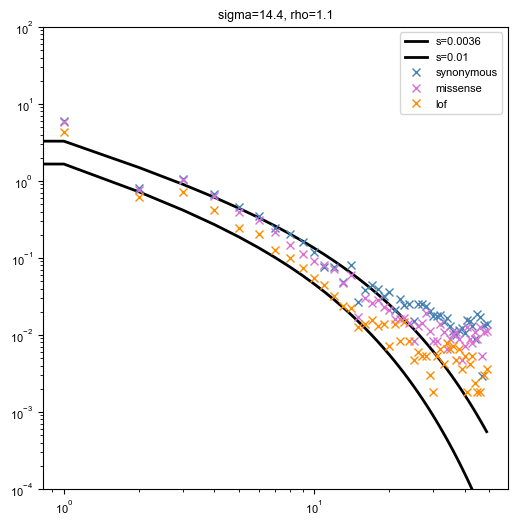

In [101]:
## sigma=10, rho 1, w=50

colors = ['darkorange', 'orchid', 'steelblue']

sigma = 14.4
mu = 1.25e-8
w = 50
n = 10000
rho = 1.1
max_x = 50
colors=['darkorange','orchid','steelblue']

fig,ax = plt.subplots(1,1,figsize=(6,6))
for i,s in enumerate([3.6e-03,0.01]):#):
    nb_dist = [get_sfs_theory(y, n, mu, s, rho, sigma, w)*1000 for y in np.arange(0, max_x)]
    ax.loglog(np.arange(0, max_x), nb_dist, marker=None, linestyle='-',linewidth=2, alpha=1, color='black',label=f's={s}')
ax.loglog(np.arange(0,max_x),sfs_list[0][:max_x],marker='x',color='steelblue',linestyle='',label='synonymous')
ax.loglog(np.arange(0,max_x),sfs_list[1][:max_x],marker='x',color='orchid',linestyle='',label='missense')
ax.loglog(np.arange(0,max_x),sfs_list[2][:max_x],marker='x',color='darkorange',linestyle='',label='lof')
ax.legend()
ax.set_ylim(1e-4,1e2)
ax.set_title(f'sigma={sigma}, rho={rho}')
plt.show()

In [ ]:
# try for smoother grid for better fitting 

### fit missense variants for w=50 (show fitted line) 
### hold sigma, rho, s to same values from w=50 fitting, plot the theory + data results for w=100  and 500 cases (only thing that changes is w)
### Reasoning: this set fits missense, we predict how results change with w -> look at how it changes
### theory should break down around the uniform case 

### if this plays out nicely - great - if not, search where objective function is over 2 values of w (50, 100)
### -> find one choice of sigma, rho, s that minimizes the sum of the objective function (sum of chi^2 over 2 scales)

# synonymous variants - wave hands, weaker selected
# show all 3 categories 
# pairwise plots between sigma and row on obj function surface?


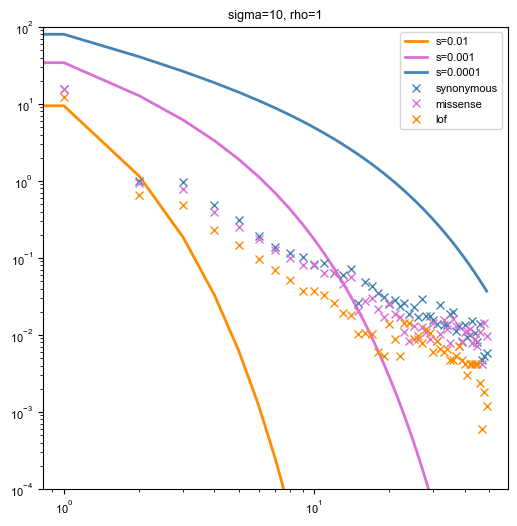

In [34]:
## sigma=10, rho 1, w=500

colors = ['darkorange', 'orchid', 'steelblue']

sigma = 10
mu = 1.25e-8
w = 500
n = 10000
rho = 1
max_x = 50
colors=['darkorange','orchid','steelblue']

fig,ax = plt.subplots(1,1,figsize=(6,6))
for i,s in enumerate([1e-2,1e-3,1e-4]):
    nb_dist = [get_sfs_theory(y, n, mu, s, rho, sigma, w)*1000 for y in np.arange(0, max_x)]
    ax.loglog(np.arange(0, max_x), nb_dist, marker=None, linestyle='-',linewidth=2, alpha=1, color=colors[i],label=f's={s}')
ax.loglog(np.arange(0,max_x),sfs_list[0][:max_x],marker='x',color='steelblue',linestyle='',label='synonymous')
ax.loglog(np.arange(0,max_x),sfs_list[1][:max_x],marker='x',color='orchid',linestyle='',label='missense')
ax.loglog(np.arange(0,max_x),sfs_list[2][:max_x],marker='x',color='darkorange',linestyle='',label='lof')
ax.legend()
ax.set_ylim(1e-4,1e2)
ax.set_title(f'sigma={sigma}, rho={rho}')
plt.show()

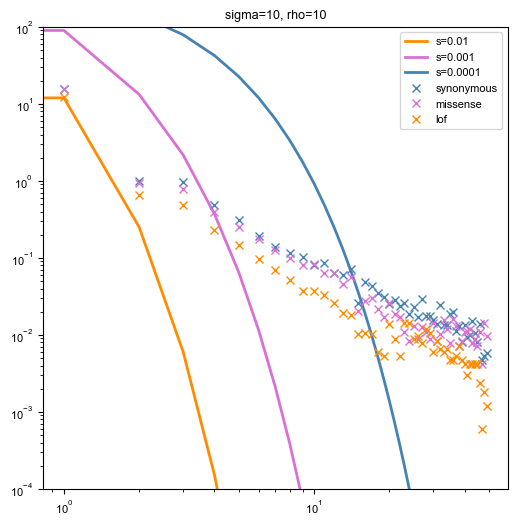

In [35]:
## sigma=10, rho 10, w=500

colors = ['darkorange', 'orchid', 'steelblue']

sigma = 10
mu = 1.25e-8
w = 500
n = 10000
rho = 10
max_x = 50
colors=['darkorange','orchid','steelblue']

fig,ax = plt.subplots(1,1,figsize=(6,6))
for i,s in enumerate([1e-2,1e-3,1e-4]):
    nb_dist = [get_sfs_theory(y, n, mu, s, rho, sigma, w)*1000 for y in np.arange(0, max_x)]
    ax.loglog(np.arange(0, max_x), nb_dist, marker=None, linestyle='-',linewidth=2, alpha=1, color=colors[i],label=f's={s}')
ax.loglog(np.arange(0,max_x),sfs_list[0][:max_x],marker='x',color='steelblue',linestyle='',label='synonymous')
ax.loglog(np.arange(0,max_x),sfs_list[1][:max_x],marker='x',color='orchid',linestyle='',label='missense')
ax.loglog(np.arange(0,max_x),sfs_list[2][:max_x],marker='x',color='darkorange',linestyle='',label='lof')
ax.legend()
ax.set_ylim(1e-4,1e2)
ax.set_title(f'sigma={sigma}, rho={rho}')
plt.show()